# AlexNet

This notebook is going to play around with the AlexNet network, which was considered a major breakthrough in computer vision when published in 2012. See

Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM 60, 6 (June 2017), 84–90. [https://doi.org/10.1145/3065386](https://doi.org/10.1145/3065386)

In [7]:
# import statements
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [8]:
# Setup
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Utility used to help with GPU memory management
def empty_cache():
    if device == "cuda":
        torch.cuda.empty_cache()
    elif device == "mps":
        torch.mps.empty_cache()

Using mps device


## The data set

Before we get to AlexNet, we're going to start with a simple data set, much simpler than the one used in AlexNet. The reason for using a different data set for starting is mostly performance. The data set used for AlexNet was quite large, and it's overkill for the initial models we'll build. We'll move to the full data set later, and keep tweaking from there.

Note: there are two downloads you'll need in your working directory, described in the code below.

In [3]:
# Data downloaded from https://www.kaggle.com/datasets/ajayrana/hymenoptera-data
ddir = 'hymenoptera_data'

# Data normalization and augmentation transformations for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B

train_transformers = v2.Compose([
    v2.ToTensor(),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
])
test_transformers v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(224),
    v2.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
])

train_dataset = 
    
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True) 
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes


Number of training samples: 50000
Number of validation samples: 10000
Number of test samples: 10000


In [5]:
# Imagenet classes downloaded from
# https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", 'r') as file:
    lines = [line.strip() for line in file]
bee_index = lines.index("bee")
ant_index = lines.index("ant")

print(f"bee_index: {bee_index}")
print(f"ant_index: {ant_index}")

bee_index: 309
ant_index: 310


## Linear Regression

The simplest neural network we can create is linear regression. Each 28x28 image gets converted to a length 784 vector $x$, with each value corresponding to a single pixel value. These are the inputs to the neural network. Each label gets converted to a length 10 vector $y$, where each value is zero except for the index corresponding to the label. That value is one. This encoding scheme is known as *one-hot encoding*. The model we then use is

$$
y = W^T x + b
$$

$W$ and $b$ are the parameter of the model that the neural net estimates. $W$ is length 784x10 vector of parameters, and $b$ is a length 10 vector of biases.

In [5]:
input_width = 28
input_size = input_width * input_width
output_size = 10

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

linear_model = LinearRegression(input_size, output_size)
linear_model.to(device)
print(linear_model)

LinearRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## Stochastic Gradient Descent

[Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is an optimization technique used in machine learning to train models by minimizing a *loss function*. Instead of using the entire dataset at once, SGD updates the model's parameters (its weights) by computing gradients based on smaller subsets of data called batches. The size of each batch, known as the *batch size*, determines how many data points are used per update. An *epoch* is one complete pass through the entire dataset. The size of each step taken during the optimization process is controlled by the *learning rate*, which determines how much the parameters are adjusted in response to the gradient. To improve convergence, *momentum* is often added, which helps the optimization process move faster by maintaining some influence from the previous update, smoothing out the learning process. *Weight decay* is a regularization technique that discourages overly large weights by adding a small penalty to the loss function, which helps prevent overfitting. Together, these concepts allow SGD to efficiently learn from data and adjust the model to perform better on unseen examples.

The standard loss function for linear regression is the *mean square error (MSE)*. For a set of labels $\{y_1, \ldots, y_n\}$, and an estimated set of of labels $\{\hat{y}_1, \ldots, \hat{y}_n\}$, the MSE is

$$
MSE(\{y_1, \ldots, y_n\}, \{\hat{y}_1, \ldots, \hat{y}_n\}) = \frac{1}{nd} \sum_{i=1}^n \| y_i - \hat{y}_i \|^2.
$$

Here $n$ is the batch size, and $d$ is the number of output dimensions. Note that this code adjusts the learning rate dynamically. This same appraoch is done in AlexNet. In particular, whenever the loss failed to improve epoch-over-epoch, they divided the learning rate by 10. Let's try that and see if that helps with convergence. This code does the same.


Epoch: 40 / 40 

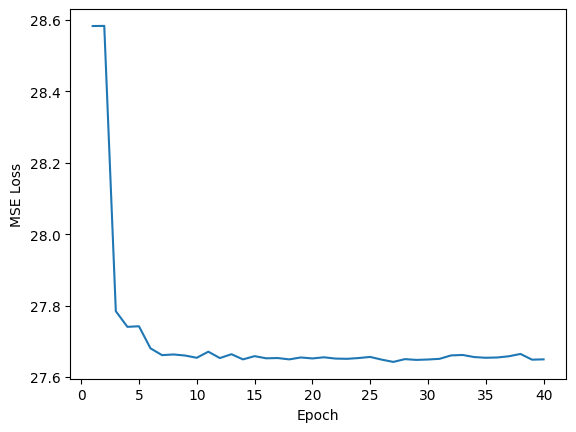

In [7]:
epochs = 40
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
mse = nn.MSELoss()

def train_and_plot(model, train_loader, criterion):
    model.train()

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    x = np.arange(1, epochs + 1)
    y = np.zeros(epochs)

    print("Epoch:  0 / 40 ", end="\r")

    last_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        y[epoch] = epoch_loss
        print(f"Epoch: {epoch + 1:2} / 40", end = "\r")

        if epoch_loss >= last_loss:
            # Reduce learning rate by a factor of 10 if loss didn't improve
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10
        last_loss = epoch_loss

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    plt.show()

train_and_plot(linear_model, train_loader, mse)

Now we'll look at how well this model performs on our validation data. Note that for a given input, our model can output any value in $\mathbb{R}^10$. Each label however is always a length 10 vector of zeros and ones, with a single value equal to one. To turn our regression model into a classifier, we need to transform our output $y_{pred}$ to $\hat{y}_{pred}$, where:

$$
\hat{y}_{pred}[i] = \begin{cases}
1, & i = \mathop{\mathrm{argmax}} \{i \in 1, \ldots, 10 \mid  y_{pred}[i]\}\\
0, & \mathrm{else}
\end{cases}
$$

Then we evaluate the model based on what percentage of the time it accurately predicted the output:

In [8]:
def evaluate_model_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            max_indices = torch.argmax(outputs, dim=1)
            predicted = torch.zeros_like(outputs)
            predicted.scatter_(1, max_indices.unsqueeze(1), 1)
            total += labels.size(0)
            correct += (predicted == labels).all(dim=1).int().sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2%}")

evaluate_model_accuracy(linear_model, validation_loader)

Accuracy: 82.40%


This accuracy, while better than a coin toss, is pretty "meh". We'll tweak this model to see if we can improve the accuracy.

## Softmax Regression

Before we do any tweaking, let's clean up the model a bit, to account for the fact that we are building a classifier, not trying to fit a function (regression), and we're using regression. In our current model, the output can be any number in $\mathbb{R}^{10}$, but it would be nice if we could interpret the outputs as probabilities. If we apply the *softmax* function to each output while we train the model, we can do just that. 

The softmax function is a mathematical transformation often used in machine learning to convert a vector of raw scores (logits) into a vector of probabilities, where each value lies between 0 and 1, and the total sum of the probabilities is 1. For a given input vector $y$, the softmax function is defined as 
$$
\text{softmax}(y_i) = \frac{e^{y_i}}{\sum_{j=1}^n e^{y_j}}
$$
This ensures that higher scores correspond to higher probabilities while maintaining relative magnitudes. Softmax is commonly used in the output layer of classification models, especially in multi-class problems, to represent the model's confidence in each class. It is also differentiable, making it compatible with gradient-based optimization algorithms like backpropagation.

In [9]:
class SoftmaxModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftmaxModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'linear_model' in locals():
    del linear_model
empty_cache()

softmax_model = SoftmaxModel(input_size, output_size)
softmax_model.to(device)
print(softmax_model)


SoftmaxModel(
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)


Before we train the model, we're going to change the loss function, to take advantage of the fact that our outputs represent probablities. We'll use the *cross-entropy loss* for this.

Cross-entropy loss is a widely used loss function for classification tasks, particularly in machine learning models that output probabilities, such as those using softmax activation. It measures the difference between the predicted probability distribution and the true distribution of the labels. For a single data point, the cross-entropy loss is defined as:
$$
-\sum_{i} y_i \log(\hat{y}_i),
$$
where $y_i$ is the true label (1 for the correct class and 0 otherwise), and $\hat{y}_i$ is the predicted probability for class $i$. Intuitively, it penalizes predictions that assign low probabilities to the correct class, with higher penalties for greater mismatches between the predicted and true distributions. Cross-entropy loss is differentiable, making it suitable for optimization in deep learning frameworks, and is commonly paired with a softmax output layer in multi-class classification problems.

Now we're ready to adapt our training method.

Epoch: 40 / 40 

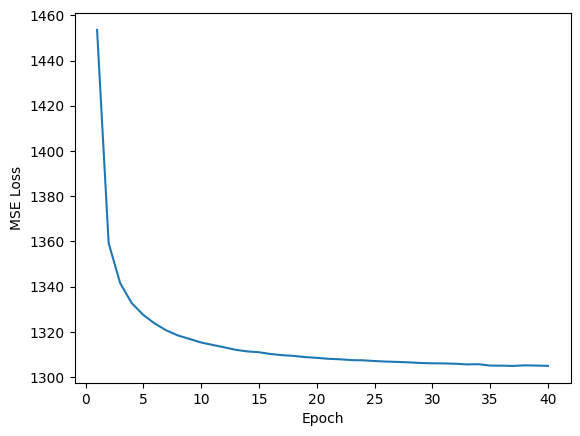

In [10]:
cross_entropy = nn.CrossEntropyLoss()
train_and_plot(softmax_model, train_loader, cross_entropy)

Now let's measure the accuracy of this model as a predictor:

In [11]:
evaluate_model_accuracy(softmax_model, validation_loader)

Accuracy: 80.98%


## Hidden Layers with ReLU

Adding "hidden" layers to a neural network can often improve performance. Hidden layers are the intermediate layers in a neural network situated between the input layer and the output layer. They are composed of neurons, or units, that process input data through learned weights and biases, applying an activation function to introduce nonlinearity. This nonlinearity allows the network to model complex patterns and relationships in the data, transforming raw inputs into higher-level feature representations. Each hidden layer outputs a set of features that serve as inputs to the next layer, enabling the network to build hierarchical features incrementally. For instance, in image processing, early hidden layers might detect edges, while deeper layers combine those edges into shapes and eventually objects. The depth (number of hidden layers) and width (number of neurons per layer) of the hidden layers determine the model's capacity to learn from data, with deeper and wider networks generally being more powerful but requiring careful tuning to avoid overfitting or excessive computational costs.

A hidden layer enhances the model's capacity to learn and represent complex, nonlinear relationships in the data. Each hidden layer acts as a transformation stage, enabling the network to build hierarchical features. For example, in an image recognition task, the first layer may detect edges, the next might combine edges into shapes, and deeper layers could identify objects. This hierarchical learning allows the network to generalize better to complex patterns that simpler models cannot capture. Furthermore, the universal approximation theorem states that a neural network with at least one hidden layer can approximate any continuous function, but adding more hidden layers can achieve this approximation more efficiently for intricate tasks. However, while deeper networks often improve performance, this is contingent on proper training techniques, such as good initialization, regularization, and optimization strategies, to avoid issues like overfitting or vanishing gradients.

The non-linear activation function used AlexNet is the Rectified Linear Unit (ReLU). ReLU is commonly used in neural networks to introduce nonlinearity, enabling them to learn complex patterns in data. Mathematically, ReLU is defined as:
$$
f(x) = \max(0, x),
$$
meaning it outputs $x$ if $x$ is positive, and 0 otherwise. Its simplicity and efficiency make it a popular choice in deep learning, as it avoids some drawbacks of earlier activation functions like sigmoid and tanh, such as vanishing gradients. ReLU's unbounded positive range allows for faster convergence during training, while its sparse activation (outputting 0 for negative inputs) enhances computational efficiency and can improve the network's ability to generalize. Despite its advantages, ReLU can suffer from the ``dying ReLU'' problem, where neurons output zero for all inputs, effectively becoming inactive. Variants like Leaky ReLU and Parametric ReLU address this issue by allowing small, non-zero outputs for negative inputs.

In [13]:
dense_width = 49 # width of hidden layer

class LayeredModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LayeredModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, dense_width),
            nn.ReLU(),
            nn.Linear(dense_width, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'softmax_model' in locals():
    del softmax_model
empty_cache()

layered_model = LayeredModel(input_size, output_size)
layered_model.to(device)
print(layered_model)

LayeredModel(
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


Epoch: 40 / 40 

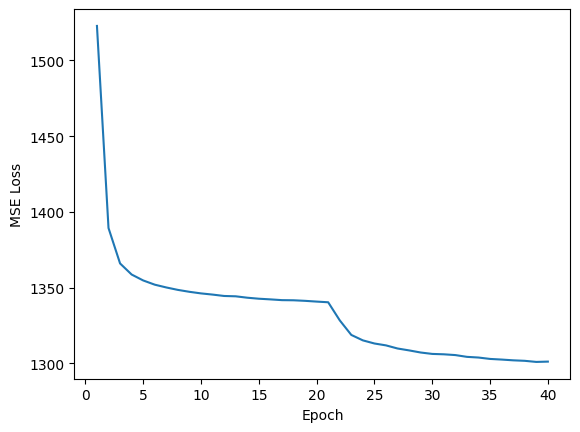

In [14]:
# Training the model
train_and_plot(layered_model, train_loader, cross_entropy)

In [15]:
# Validating the model
evaluate_model_accuracy(layered_model, validation_loader)

Accuracy: 79.54%


Note that our accuracy got worse when adding the hidden layer. We just added a bunch of parameters, but didn't increase the data size, so this might not be any surprise. If we ditch the hidden layer, we fix this problem, but we miss out on the opportunity to have the nueral net learn a more complex, hierarchical structure. So as not to throw the baby out with the bathwater, we'll use dropout.

## Dropout

Dropout is a regularization technique used in neural networks to prevent overfitting and improve generalization. During training, dropout randomly "drops out" a fraction of neurons in a layer by setting their outputs to zero with a predefined probability, typically ranging from 0.2 to 0.5. This forces the network to rely on multiple independent feature representations rather than overfitting to specific patterns in the training data. By doing so, it reduces the co-adaptation of neurons and makes the network more robust. During inference, dropout is disabled, and all neurons contribute to the predictions, but their weights are scaled to account for the training phase dropout. This technique is simple to implement and is widely used in deep learning models to enhance their ability to generalize to unseen data. In AlexNet, they use a dropout factor of 0.5.

In [16]:
dropout = 0.5

class DropoutModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DropoutModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_size, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'layered_model' in locals():
    del layered_model
empty_cache()

dropout_model = DropoutModel(input_size, output_size)
dropout_model.to(device)
print(dropout_model)

DropoutModel(
  (stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=49, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=49, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


Epoch: 40 / 40 

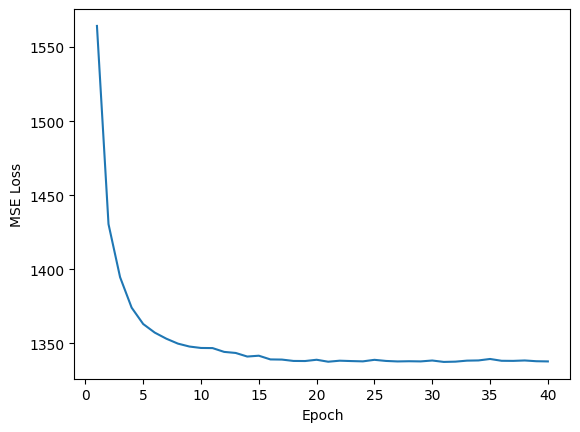

In [17]:
train_and_plot(dropout_model, train_loader, cross_entropy)

In [18]:
evaluate_model_accuracy(dropout_model, validation_loader)

Accuracy: 79.81%


## A Larger Model

In [19]:
class DeeperModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeeperModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(input_size, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'dropout_model' in locals():
    del dropout_model
empty_cache()

deeper_model = DropoutModel(input_size, output_size)
deeper_model.to(device)
print(deeper_model)

DropoutModel(
  (stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=49, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=49, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


Epoch: 40 / 40 

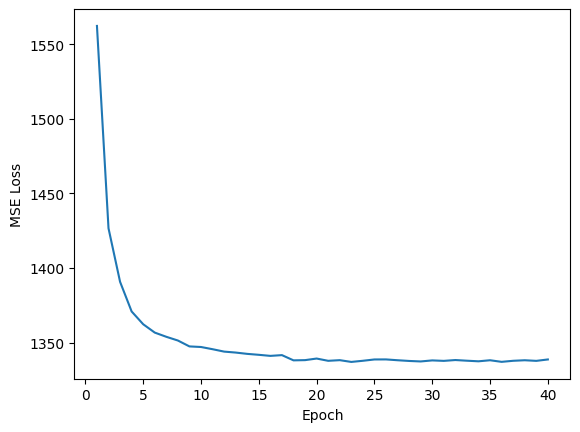

In [20]:
train_and_plot(deeper_model, train_loader, cross_entropy)

In [21]:
accuracy = evaluate_model_accuracy(deeper_model, validation_loader)

Accuracy: 79.80%


## Convolutional Layers

Convolutional layers are fundamental building blocks in convolutional neural networks (CNNs), designed to efficiently extract features from spatial data like images or videos. Unlike fully connected layers, which treat each input feature independently, convolutional layers leverage the spatial structure of the input by applying a set of learnable filters (kernels) over small, localized regions of the input. Each filter detects specific patterns, such as edges, textures, or shapes, by sliding (convolving) across the input, producing feature maps that highlight these patterns. Convolutional layers are computationally efficient because they use weight sharing, where the same filter is applied across the entire input, significantly reducing the number of learnable parameters compared to fully connected layers. Additionally, by stacking multiple convolutional layers, a CNN can learn hierarchical features, with earlier layers capturing simple patterns and deeper layers detecting more complex structures. These properties make convolutional layers particularly effective for tasks like image classification, object detection, and semantic segmentation.

Let's add a convolutional layer at the beginning of our network.

In [22]:
kernal_width = 3

class ConvolutionalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvolutionalModel, self).__init__()
        conv_output_size = (input_width - kernal_width + 1)**2
        self.stack = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(1, 1, (kernal_width, kernal_width)),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(conv_output_size, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'deeper_model' in locals():
    del deeper_model
empty_cache()

convolutional_model = ConvolutionalModel(input_size, output_size)
convolutional_model.to(device)
print(convolutional_model)

ConvolutionalModel(
  (stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=676, out_features=49, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=49, out_features=49, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=49, out_features=10, bias=True)
    (11): Softmax(dim=1)
  )
)


Epoch: 40 / 40 

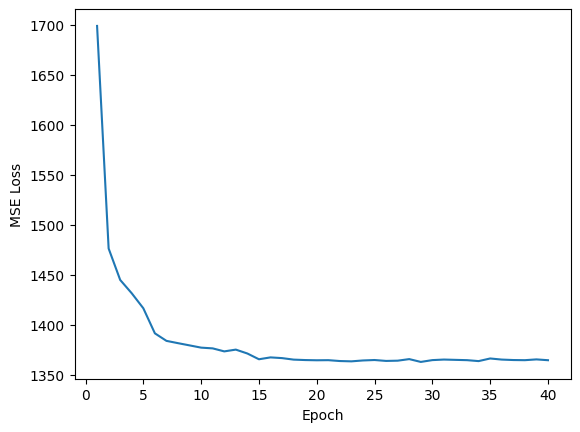

In [23]:
train_and_plot(convolutional_model, train_loader, cross_entropy)

In [24]:
evaluate_model_accuracy(convolutional_model, validation_loader)

Accuracy: 77.73%


## Max Pooling


Max pooling is a down-sampling operation used in convolutional neural networks (CNNs) to reduce the spatial dimensions of feature maps while retaining the most significant information. It works by sliding a pooling window (e.g., 2×2) over the input feature map and selecting the maximum value within each region. This helps reduce computational complexity, prevent overfitting, and make the model more robust to spatial translations of the input. Using overlap in max pooling, where the pooling regions partially overlap due to a stride smaller than the pooling window size, can preserve more spatial detail compared to non-overlapping pooling. Overlap is beneficial in scenarios where finer granularity in the feature representation is crucial, as it reduces the risk of losing important local features at the cost of slightly increased computational load. Overlapping max pooling provides a smoother transition between regions and can improve performance in tasks requiring high spatial precision.

In [25]:
pool_width = 3
stride_width = 2

class PoolingModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoolingModel, self).__init__()
        conv_output_width = input_width - kernal_width + 1
        pool_output_width = (conv_output_width - pool_width) // 2 + 1
        pool_output_size = pool_output_width**2
        self.stack = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(1, 1, (kernal_width, kernal_width)),
            nn.MaxPool2d(pool_width, stride=stride_width),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(pool_output_size, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'convolutional_model' in locals():
    del convolutional_model
empty_cache()

pooling_model = PoolingModel(input_size, output_size)
pooling_model.to(device)
print(pooling_model)

PoolingModel(
  (stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=144, out_features=49, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=49, out_features=49, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=49, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


Epoch: 40 / 40 

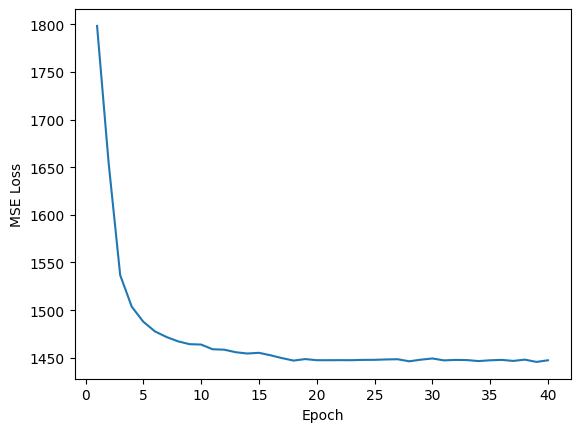

In [27]:
train_and_plot(pooling_model, train_loader, cross_entropy)

In [28]:
accuracy = evaluate_model_accuracy(pooling_model, validation_loader)

Accuracy: 65.13%


## Data Augmentation

To enlarge the dataset, AlexNet used two types of *data augmentation*. Data augmentation techniques generate new data points from existing ones in label-preserving ways, to simulate having more data for training. One data augmentation set used in AlexNet involved color manipulation, and since the smaller data set here is black and white, doesn't apply. The other was to extract random patches from the images, with random horizontal reflections, to enlarge the data set.

In [34]:
class AugmentedModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(AugmentedModel, self).__init__()
        conv_output_width = (input_width - 4) - kernal_width + 1
        pool_output_width = (conv_output_width - pool_width) // 2 + 1
        pool_output_size = pool_output_width**2
        self.stack = nn.Sequential(
            v2.RandomCrop(size=(24, 24)),
            v2.RandomHorizontalFlip(p=0.5),
            nn.Dropout(dropout),
            nn.Conv2d(1, 1, (kernal_width, kernal_width)),
            nn.MaxPool2d(pool_width, stride=stride_width),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(pool_output_size, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, dense_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dense_width, output_size),
            nn.Softmax(dim=1)
        )
            
    def forward(self, x):
        x = self.stack(x)
        return x


# Free up GPU space from the old model:
if 'pooling_model' in locals():
    del pooling_model
empty_cache()

augmented_model = AugmentedModel(input_size, output_size)
augmented_model.to(device)
print(augmented_model)

AugmentedModel(
  (stack): Sequential(
    (0): RandomCrop(size=(24, 24), pad_if_needed=False, fill=0, padding_mode=constant)
    (1): RandomHorizontalFlip(p=0.5)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=100, out_features=49, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=49, out_features=49, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=49, out_features=10, bias=True)
    (14): Softmax(dim=1)
  )
)


Epoch: 40 / 40 

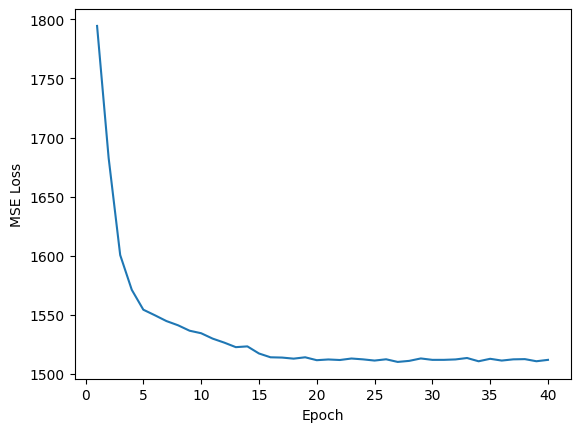

In [35]:
train_and_plot(augmented_model, train_loader, cross_entropy)

In [37]:
accuracy = evaluate_model_accuracy(augmented_model, validation_loader)

Accuracy: 53.72%


## A Larger Dataset

The real AlexNet runs on a much larger data set. The implemetation uses the above building blocks, but it's not implemented here, because it would be quite slow to run.